<a href="https://colab.research.google.com/github/wjcai/ECG_lead_check/blob/main/limb_lead_misplacement_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/wjcai/ECG_lead_check.git

Cloning into 'ECG_lead_check'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 7), reused 28 (delta 3), pack-reused 0
Receiving objects: 100% (40/40), 1.51 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
from ECG_lead_check.limb.LDenseNet import build_model
#Build LDenseNet, the model input shape is (1200,3), each channel corresponds to III, avR, and V6.
#The four output categories correspond to Normal, LA-RA, RA-LL, and LA-LL.
model = build_model(input_shape=(1200,3), output_dims=4)
# load model weights
model.load_weights('/content/ECG_lead_check/saved_model/LDenseNet/')
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1200, 3)]            0         []                            
                                                                                                  
 conv1d_42 (Conv1D)          (None, 600, 16)              544       ['input_7[0][0]']             
                                                                                                  
 activation_42 (Activation)  (None, 600, 16)              0         ['conv1d_42[0][0]']           
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 300, 16)              0         ['activation_42[0][0]']       
 g1D)                                                                                       

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#load samples
normal_sample = np.load('/content/ECG_lead_check/example/samples.npy')
print(normal_sample.shape)

(10, 5000, 12)


In [ ]:
#choose III, avR, and V6 as model input
model_input = normal_sample[:,:,[2,3,-1]]
print(model_input.shape)

(10, 5000, 3)


In [ ]:
#define the plot function, x is the ecg with the shape of (signal lens, channel)
def plot_ecgs(x):
    for i in range(x.shape[-1]):
        plt.subplot(x.shape[-1], 1, i+1)
        plt.plot(x[:, i])
    plt.show()

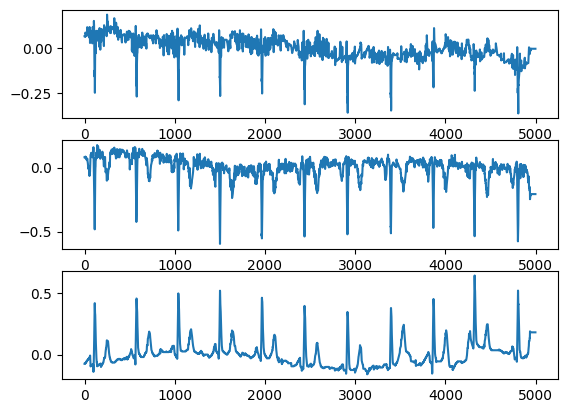

In [ ]:
# choose one sample for display
plot_ecgs(model_input[0])

In [ ]:
#preprocess the ecgs
!pip install neurokit2
import neurokit2 as nk
import scipy.signal
# define data preprocess function
#raw_data shape: (Sample number, signal length, channel)
def preprocess_data(raw_data):
    def leads_preprocess(leads):
        pre_leads = []
        for i in range(leads.shape[0]):
            lead = leads[i]
            #5-order Butterworth bandpass filter, with a lower limit of 0.5Hz and an upper limit of 35Hz
            lead = nk.signal_filter(lead, sampling_rate=500, lowcut=0.5, highcut=35, order=5) # denoise by butterworth bandpass filter
            #downsample the signals from 500Hz to 120 Hz
            lead = scipy.signal.resample(lead, int(lead.shape[0]/500*120)) #downsample to 120Hz
            #Z-score normalization
            lead = (lead - np.mean(lead)) / np.std(lead) if np.std(lead)!=0 else np.zeros_like(lead) # Z-score normalization
            pre_leads.append(lead)
        pre_leads = np.array(pre_leads)
        return pre_leads

    raw_data = np.transpose(raw_data, [0,2,1])
    preprocessed_data = []
    for i in range(raw_data.shape[0]):
        ecgs = leads_preprocess(raw_data[i])
        preprocessed_data.append(ecgs)
    preprocessed_data = np.array(preprocessed_data, dtype = 'float32')
    preprocessed_data = np.transpose(preprocessed_data, [0,2,1])
    return preprocessed_data

(10, 1200, 3)


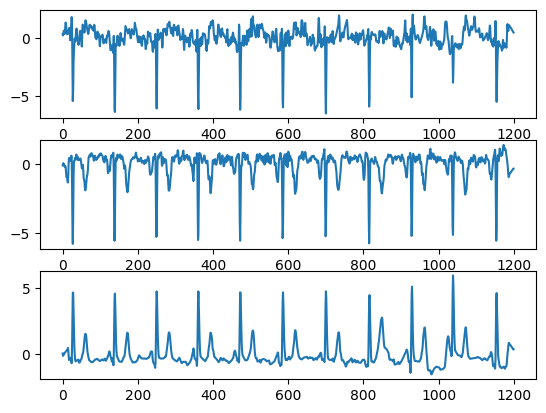

In [ ]:
# perform preprocess on samples and display
model_input = preprocess_data(model_input)
print(model_input.shape)
plot_ecgs(model_input[0])

In [ ]:
#limb lead misplacement detection
# 0: Normal, 1:LA-RA, 2:RA-LL, 3:LA-LL
result = model.predict(model_input)
result = np.argmax(result, axis=-1)
print(result) # all normal, note the samples contain no records of lead misplacement

1/1 [==============================] - 1s 660ms/step
[0 0 0 0 0 0 0 0 0 0]


In [ ]:
#simulate limb lead misplacement, according to Table 1
#mode corresponds to different misplacement situation
def interchange_transform(mode,normal_leads):
    transformed_leads = np.copy(normal_leads)
    if mode == 1:#LA-RA
        transformed_leads[0]=-normal_leads[0]
        transformed_leads[1]=normal_leads[2]
        transformed_leads[2]=normal_leads[1]
        transformed_leads[3]=normal_leads[4]
        transformed_leads[4]=normal_leads[3]
    elif mode == 2:#RA-LL
        transformed_leads[0]=-normal_leads[2]
        transformed_leads[1]=-normal_leads[1]
        transformed_leads[2]=-normal_leads[0]
        transformed_leads[3]=normal_leads[5]
        transformed_leads[5]=normal_leads[3]
    elif mode == 3:#LA-LL
        transformed_leads[0]=normal_leads[1]
        transformed_leads[1]=normal_leads[0]
        transformed_leads[2]=-normal_leads[2]
        transformed_leads[4]=normal_leads[5]
        transformed_leads[5]=normal_leads[4]
    else:
        pass
    return transformed_leads

(10, 12, 5000)
(10, 1200, 3)


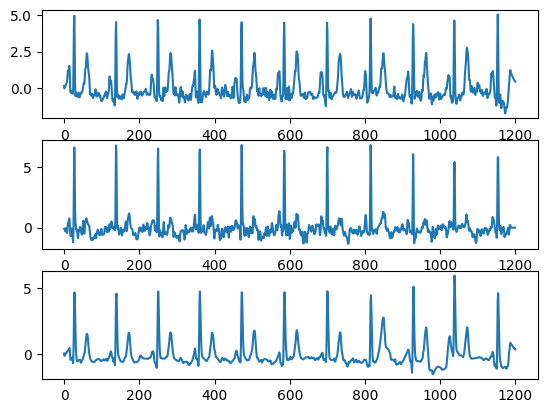

In [ ]:
limb_leads_misplacement_samples = np.copy(normal_sample)
limb_leads_misplacement_samples = np.transpose(limb_leads_misplacement_samples, [0,2,1])
print(limb_leads_misplacement_samples.shape)
#perform different misplacement simulations on Normal samples
mode = [1,2,3,0,1,2,3,0,1,2]
for i in range(normal_sample.shape[0]):
    limb_leads_misplacement_samples[i] = interchange_transform(mode[i],limb_leads_misplacement_samples[i])
limb_leads_misplacement_samples = np.transpose(limb_leads_misplacement_samples, [0,2,1])
model_input = limb_leads_misplacement_samples[:,:,[2,3,-1]]
model_input = preprocess_data(model_input)
print(model_input.shape)
plot_ecgs(model_input[0])

In [ ]:
# 0: Normal, 1:LA-RA, 2:RA-LL, 3:LA-LL
result = model.predict(model_input)
result = np.argmax(result, axis=-1)
print(result)

1/1 [==============================] - 0s 44ms/step
[1 2 3 0 1 2 3 0 1 2]
